In [1]:
from matplotlib import pyplot as plt
import torch
import random
import numpy as np
import tracing
import cv2
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [2]:
height = 512
model_name = 'models/new_loss_model.pt'
model = tracing.Segmenter(model_name,height)
finder = tracing.Points_finder()

In [3]:
image,result = model('data/image1.png')

torch.Size([1, 3, 512, 512])


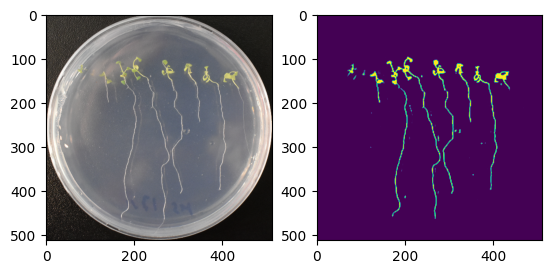

In [4]:
result.reshape(1, height, height)
mask = result[0].cpu().permute(1,2,0).detach().numpy()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(image)
axarr[1].imshow(mask)

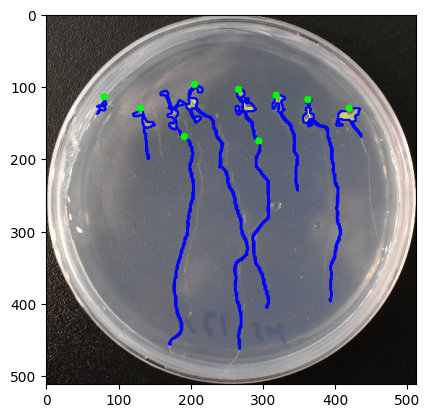

In [5]:
points_pic,start_points = finder.plot(mask,image)
plt.imshow(points_pic)

In [6]:
def find_next_point_directionally(current_point, direction, search_window, image, mask):
    x, y = current_point
    if direction is None:
        direction = (0, 1)  # Если направление не определено, используем стандартное (например, вертикально вниз)

    best_point = current_point
    max_match = 0
    new_direction = direction
    angle_range = np.pi / 3  # Угловой диапазон для поиска

    angle_direction = np.arctan2(direction[1], direction[0])  # Направление движения в радианах
    half_window_size = search_window // 2

    for dx in range(-half_window_size, half_window_size + 1):
        for dy in range(-half_window_size, half_window_size + 1):
            nx, ny = x + dx, y + dy
            if (nx, ny) == current_point:
                continue  # Пропускаем изначальную точку
            if 0 <= nx < image.shape[1] and 0 <= ny < image.shape[0] and mask[ny, nx] > 0:
                angle_to_point = np.arctan2(dy, dx)
                angle_diff = np.abs((angle_to_point - angle_direction) % (2 * np.pi))

                # Проверка, находится ли точка в разрешенном угловом диапазоне
                if angle_diff <= angle_range or angle_diff >= (2 * np.pi - angle_range):
                    pixel_value = image[ny, nx]
                    if pixel_value > max_match:
                        max_match = pixel_value
                        best_point = (nx, ny)
                        new_direction = (dx, dy)

    return best_point, new_direction

In [7]:
def trace_root(start_point, image, mask, max_steps=100, search_window=5):
    points = [start_point]
    current_point = start_point
    direction = None  

    for _ in range(max_steps):
        next_point, new_direction = find_next_point_directionally(current_point, direction, search_window, image, mask)
        if next_point == current_point:
            search_window += 5  
            if search_window > 40: 
                break
        points.append(next_point)
        current_point = next_point
        direction = new_direction

    return points

[(294, 175), (295, 178), (295, 188), (291, 197), (291, 198), (290, 208), (290, 209), (297, 218), (298, 220), (303, 226), (307, 233), (307, 240), (307, 248), (308, 257), (307, 266), (307, 267), (307, 273), (307, 280), (301, 287), (294, 296), (287, 305), (286, 308), (278, 318), (278, 328), (278, 329), (277, 331), (275, 334), (265, 341), (263, 344), (261, 350), (261, 355), (263, 365), (262, 371), (262, 372), (262, 378), (262, 380), (262, 381), (262, 382), (262, 383), (263, 389), (264, 394), (264, 395), (267, 403), (269, 413), (269, 414), (270, 424), (269, 431), (267, 439), (267, 440), (266, 445), (266, 446), (266, 447), (267, 456), (268, 462), (268, 463), (268, 463), (268, 463), (268, 463), (268, 463), (191, 169), (199, 179), (199, 180), (202, 186), (202, 187), (202, 197), (201, 202), (199, 207), (199, 215), (201, 221), (201, 222), (201, 223), (201, 225), (204, 235), (204, 242), (203, 248), (203, 255), (200, 263), (200, 268), (197, 278), (197, 281), (197, 282), (196, 288), (196, 298), (19

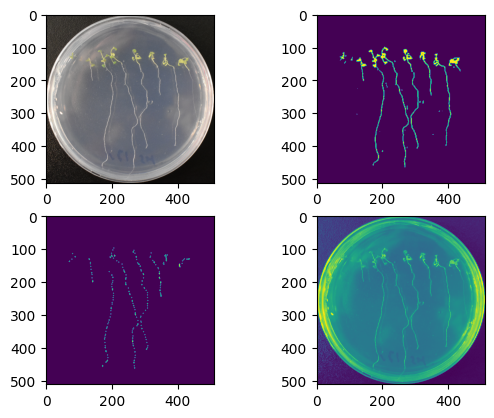

In [8]:
trace_mask = mask.copy()

_, binary_image = cv2.threshold(trace_mask,0.3, 1, cv2.THRESH_BINARY)

trace_image = cv2.cvtColor(image.copy(),cv2.COLOR_RGB2GRAY)

root_traces = []

initial_directions = [(0, 1), (1, 0)]  


for start_point in start_points:
    root_traces.extend(trace_root(start_point, trace_image.copy(), binary_image.copy(),100,20))

print(root_traces)

for trace in root_traces:
     #for point in trace:
        cv2.circle(trace_mask, trace, 1, (255, 0, 0), -1)  


f, axarr = plt.subplots(2,2) 
axarr[0][0].imshow(image)
axarr[0][1].imshow(binary_image)
axarr[1][0].imshow(trace_mask)
axarr[1][1].imshow(cv2.cvtColor(image.copy(),cv2.COLOR_RGB2GRAY))
